# かがわAIゼミナール　2020
## 課題
更新日:2010/10/12  

データセット：「Kickstarter Projects」  
 問題設定：クラウドファンデイングが成功するか(state)を予測する。

 https://www.kaggle.com/kemical/kickstarter-projects  
 データ:ks-projects-201801.csv

In [1]:
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

### CSVファイルの中身を確認する｡  

|項目|説明|目的変数|
|-|-|-|
|ID|-|-|
|name|-|-|
|category|-|-|
|main_category|category of campaign|-|
|currency|currency used to support:通貨|-|
|deadline|deadline for crowdfunding:終了|-|
|goal|目標金額|-|
|launched|date launched:開始|-|
|pledged|amount pledged by "crowd"	集まったお金|-|		
|state|結果|〇|
|backers|後援者,パトロン|-|		
|country|-|-|
|usd pledged|-|-|				
|usd_pledged_real|-|-|
|usd_goal_real|USDに換算した目標金額|-|


In [2]:
#CSVを読み込む
ks_proj = pd.read_csv("../kaggle/ks-projects-201801_csv/ks-projects-201801.csv")

In [3]:
#内容確認
ks_proj.info()
display(ks_proj.head())
ks_proj.describe(include='O')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375764,159,15,14,3164,378089,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,failed,US
freq,41,22314,63585,295365,705,7,197719,292627


In [4]:
#stateのunipueが6あるため内容を確認
ks_proj['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

今回は'failed', 'successful'のロジスティクス回帰とし、それ以外は削除する。

In [5]:
#ks2を作成
ks2= ks_proj.copy()
#state列が'failed','successful'の行を抽出する。
ks2 = ks2[ks2['state'].isin(['failed','successful'])]
#state列の'successful'を1としてフラグを立てる
ks2['state_f'] = 0
ks2.loc[ks2['state'] == 'successful', 'state_f'] = 1
display(ks2.head())
ks2.describe(include='O')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_f
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00,1


,name,category,main_category,currency,deadline,launched,state,country
count,331672,331675,331675,331675,331675,331675,331675,331675
unique,329594,159,15,14,3102,331255,2,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,2015-01-26 20:04:14,failed,US
freq,15,18680,56527,261511,612,2,197719,261360


In [6]:
ks2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 16 columns):
ID                  331675 non-null int64
name                331672 non-null object
category            331675 non-null object
main_category       331675 non-null object
currency            331675 non-null object
deadline            331675 non-null object
goal                331675 non-null float64
launched            331675 non-null object
pledged             331675 non-null float64
state               331675 non-null object
backers             331675 non-null int64
country             331675 non-null object
usd pledged         331465 non-null float64
usd_pledged_real    331675 non-null float64
usd_goal_real       331675 non-null float64
state_f             331675 non-null int64
dtypes: float64(5), int64(3), object(8)
memory usage: 43.0+ MB


## 説明変数の整理

以下は結果のデータのため説明変数としては使用しない  
pledged             378661 non-null float64  
backers             378661 non-null int64  
usd pledged         374864 non-null float64  
usd_pledged_real    378661 non-null float64  

#### nameについて
nameと成否の関係を確認する。

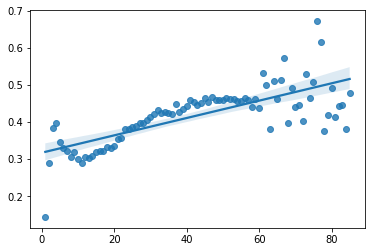

In [7]:
ks2["name_len"] = ks2.name.str.len()
#文字数でグループ化して文字数ごとの成功フラグの平均値をとることで文字数ごとの成功率を出す。
z = ks2.groupby('name_len').state_f.mean()
sns.regplot(z.index.array, z.values)

文字数が多いほうが成功率が高いことが分かった。

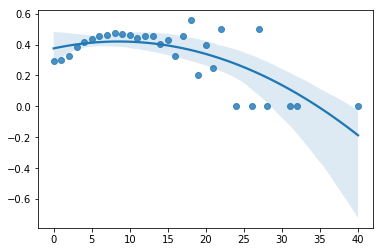

In [8]:
ks2["name_sp"] = ks2.name.str.count(" ")
z = ks2.groupby('name_sp').state_f.mean()
sns.regplot(z.index.array, z.values, order=2, truncate=True)

nameに含まれるスペースの数が15以上になると成功数が下がっていく

nameに関連する数値を説明変数とする。

#### launched,deadlineについて  
launched(開始）とdeadline(終了）の差分をとって期間を抽出する。  
objectからdatetimeに変換する。

In [9]:
##時分秒を削除する
##object→datetimeに変更（処理に時間がかかる）
ks2['launched'] = pd.to_datetime(ks2['launched'])
ks2['deadline'] = pd.to_datetime(ks2['deadline'])
ks2['days'] = (ks2['deadline'] - ks2['launched']).dt.days

ks2['days'].value_counts()

29    148478
59     27969
44     15241
30     11724
34      8619
39      8594
31      6467
20      6125
19      6059
28      5540
24      5518
32      5070
14      4860
27      4848
13      3848
33      3210
35      3017
26      2654
21      2461
25      2373
23      2305
36      2279
49      2193
9       2081
22      2061
37      1908
45      1806
41      1731
38      1682
6       1642
       ...  
2        194
1        129
62       124
65       107
87       105
64       105
69        98
0         92
63        83
70        82
74        81
75        75
71        74
66        69
67        61
86        61
79        59
85        59
68        57
84        56
80        49
77        49
72        49
82        47
83        47
81        46
76        45
73        43
78        35
91        22
Name: days, Length: 92, dtype: int64

期間と成功率
期間と成功/失敗の数を可視化してみる。

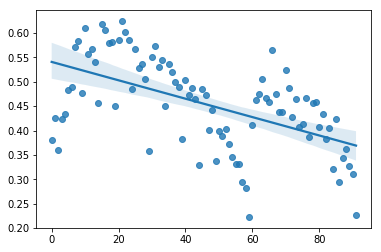

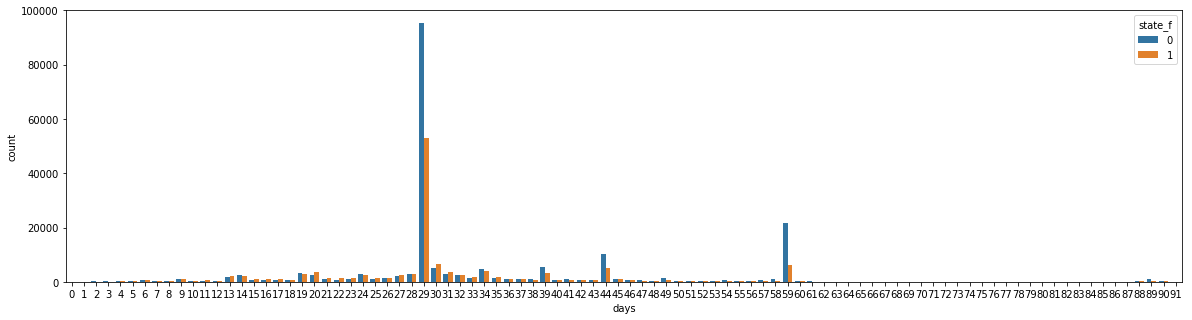

In [10]:
z = ks2.groupby('days').state_f.mean()
sns.regplot(z.index.array, z.values)

plt.figure(figsize=(20,5))
sns.countplot(data=ks2, x='days',hue='state_f')

29日（およそ1か月間） が圧倒的に多い  
全体的には日数が長くなるほど成功率が低いが、そもそも数の偏りが大きい

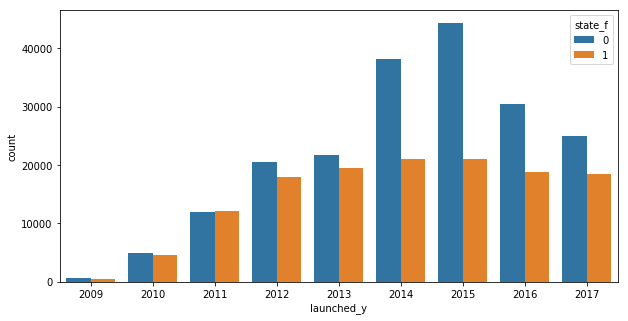

In [11]:
ks2['launched_y'] =ks2['launched'].dt.year
plt.figure(figsize=(10,5))
sns.countplot(data=ks2, x='launched_y',hue='state_f')

2014年と2015年は件数が多いが成功率が低い  
2014年と2015年は他と傾向が違うのか？

In [12]:
#ダミー変数にしてみる。
year = pd.get_dummies(ks2['launched_y'],dtype=int)
ks2 = pd.concat([ks2, year], axis=1)

期間がおよそ1か月単位ならば月による成功率の変動はあるのか？

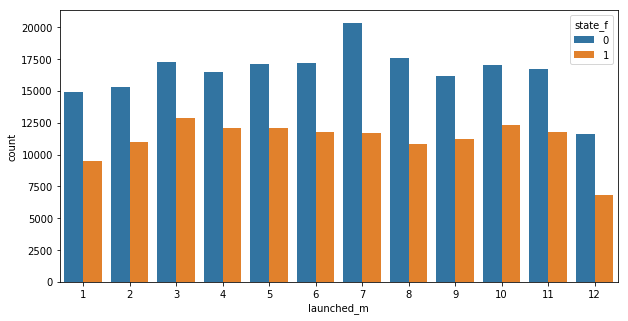

In [13]:
ks2['launched_m'] =ks2['launched'].dt.month
plt.figure(figsize=(10,5))
sns.countplot(data=ks2, x='launched_m',hue='state_f')

開始月による成功率偏りはなさそう

#### countryとcurrencyについて
country（国）とcurrency（通貨）はほぼイコールと思われる。
どやって数値で証明するか？

In [14]:
ks2['country'].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

In [15]:
#N,0"をNOに修正
ks2.loc[ks2['country'] == 'N,0"', 'country'] = 'NO'
ks2['country'].value_counts()

US    261360
GB     29454
CA     12370
AU      6616
DE      3436
FR      2520
NL      2411
IT      2369
ES      1873
SE      1509
MX      1411
NZ      1274
DK       926
NO       792
IE       683
CH       652
BE       523
AT       485
HK       477
SG       454
LU        57
JP        23
Name: country, dtype: int64

In [16]:
#currencyをダミー変数に変換
crcy = pd.get_dummies(ks2['currency'],dtype=int)
cr_cu = crcy
display(cr_cu.head())

,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [17]:
#countryをダミー変数に変換
cnty = pd.get_dummies(ks2['country'],dtype=int)
cr_cu = pd.concat([cr_cu, cnty], axis=1)
display(cr_cu.head())

,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,...,IT,JP,LU,MX,NL,NO,NZ,SE,SG,US
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
cr_cu[['USD','GBP','CAD','US','GB','CA']].corr()

,USD,GBP,CAD,US,GB,CA
USD,1.000000,-0.602942,-0.380068,0.998637,-0.602695,-0.379988
GBP,-0.602942,1.000000,-0.061484,-0.602120,0.999590,-0.061471
CAD,-0.380068,-0.061484,1.000000,-0.379550,-0.061459,0.999790
US,0.998637,-0.602120,-0.379550,1.000000,-0.601874,-0.379470
GB,-0.602695,0.999590,-0.061459,-0.601874,1.000000,-0.061446
CA,-0.379988,-0.061471,0.999790,-0.379470,-0.061446,1.000000


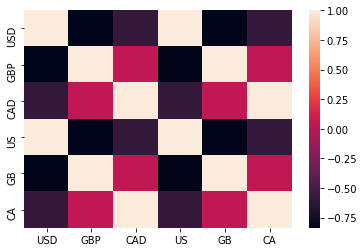

In [19]:
sns.heatmap(cr_cu[['USD','GBP','CAD','US','GB','CA']].corr().corr())
plt.show()

In [20]:
(ks2['currency'].value_counts()/ks2['currency'].count())*100

USD    78.845557
GBP     8.887013
EUR     4.334966
CAD     3.731062
AUD     1.996231
SEK     0.455265
MXN     0.425416
NZD     0.384111
DKK     0.280093
CHF     0.196578
NOK     0.176076
HKD     0.143815
SGD     0.136881
JPY     0.006934
Name: currency, dtype: float64

USDとUS,GBPとGB,CADとCAはそれぞれ0.99以上の相関でありほぼ同一である。（自国通貨を使用している）  
USDとGBとCADは全体の90%をしめており、同様にEU圏はEURと想定されるため、  
説明変数としてはcurrencyとcountryどちらか一つでよいと思われる。  
今回は種類の少ないcurrencyを採用する。

In [21]:
ks2 = pd.concat([ks2, crcy], axis=1)

#### category,main_categoryについて
categoryは159種、main_categoryは15種類のためmain_categoryを説明変数として採用する。

In [22]:
ks2['main_category'].value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [23]:
m_ctg = pd.get_dummies(ks2['main_category'],dtype=int)
ks2 = pd.concat([ks2, m_ctg], axis=1)
display(ks2.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,0,0,0,0,0,1,0,0,0,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,...,0,0,1,0,0,0,0,0,0,0


In [24]:
#'state'をTrue/Falseに変換する。
ks2['state'] = ks2['state'] == 'successful' 
display(ks2.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,...,0,0,0,0,0,1,0,0,0,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,True,...,0,0,1,0,0,0,0,0,0,0


In [25]:
ks2['state'].value_counts()

False    197719
True     133956
Name: state, dtype: int64

In [26]:
ks2.columns

Index([              'ID',             'name',         'category',
          'main_category',         'currency',         'deadline',
                   'goal',         'launched',          'pledged',
                  'state',          'backers',          'country',
            'usd pledged', 'usd_pledged_real',    'usd_goal_real',
                'state_f',         'name_len',          'name_sp',
                   'days',       'launched_y',               2009,
                     2010,               2011,               2012,
                     2013,               2014,               2015,
                     2016,               2017,       'launched_m',
                    'AUD',              'CAD',              'CHF',
                    'DKK',              'EUR',              'GBP',
                    'HKD',              'JPY',              'MXN',
                    'NOK',              'NZD',              'SEK',
                    'SGD',              'USD',              'A

In [27]:
#不要な目的変数は削除する。
ks3 = ks2.drop(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'backers', 'country',
       'usd pledged', 'usd_pledged_real','launched_y', 'state_f','launched_m'],axis=1)
display(ks3.head())

,state,usd_goal_real,name_len,name_sp,days,2009,2010,2011,2012,2013,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,False,1533.95,31.0,5.0,58,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,False,30000.00,45.0,7.0,59,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,False,45000.00,14.0,2.0,44,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,False,5000.00,49.0,6.0,29,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5,True,50000.00,20.0,2.0,34,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [28]:
ks3.isnull().sum()

state            0
usd_goal_real    0
name_len         3
name_sp          3
days             0
2009             0
2010             0
2011             0
2012             0
2013             0
2014             0
2015             0
2016             0
2017             0
AUD              0
CAD              0
CHF              0
DKK              0
EUR              0
GBP              0
HKD              0
JPY              0
MXN              0
NOK              0
NZD              0
SEK              0
SGD              0
USD              0
Art              0
Comics           0
Crafts           0
Dance            0
Design           0
Fashion          0
Film & Video     0
Food             0
Games            0
Journalism       0
Music            0
Photography      0
Publishing       0
Technology       0
Theater          0
dtype: int64

In [29]:
#欠損地が3つあるため、欠損値を含む行を削除
ks3 = ks3.dropna()
ks3.isnull().sum()

state            0
usd_goal_real    0
name_len         0
name_sp          0
days             0
2009             0
2010             0
2011             0
2012             0
2013             0
2014             0
2015             0
2016             0
2017             0
AUD              0
CAD              0
CHF              0
DKK              0
EUR              0
GBP              0
HKD              0
JPY              0
MXN              0
NOK              0
NZD              0
SEK              0
SGD              0
USD              0
Art              0
Comics           0
Crafts           0
Dance            0
Design           0
Fashion          0
Film & Video     0
Food             0
Games            0
Journalism       0
Music            0
Photography      0
Publishing       0
Technology       0
Theater          0
dtype: int64

***
パラメータの正規化/標準化を行う。
対象は'usd_goal_real','name_len','	name_sp','days'

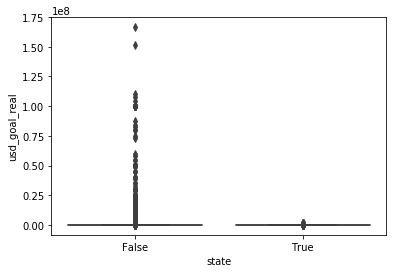

In [30]:
sns.boxplot(x="state", y="usd_goal_real", data=ks3)

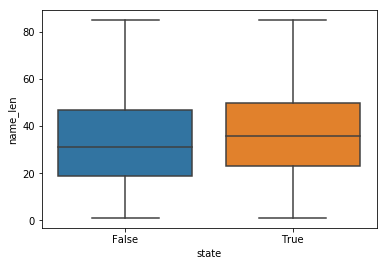

In [31]:
sns.boxplot(x="state", y="name_len", data=ks3)

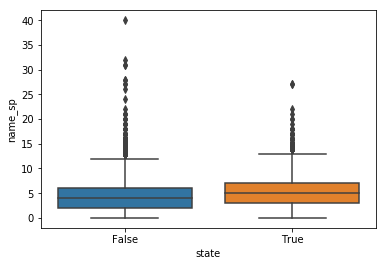

In [32]:
sns.boxplot(x="state", y="name_sp", data=ks3)

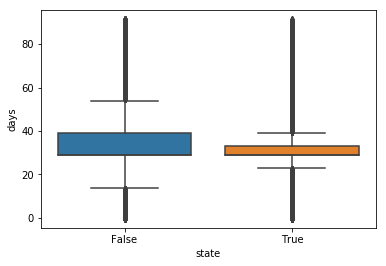

In [33]:
sns.boxplot(x="state", y="days", data=ks3)

name_lenは外れ値がないので正規化  
name_len以外は外れ値があり影響が大きそうなので標準化を行う

In [34]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
ks3['name_len'] = mms.fit_transform(ks3[['name_len']].values)

In [35]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
ks3['usd_goal_real'] = stdsc.fit_transform(ks3[['usd_goal_real']].values)

In [36]:
ks3['name_sp'] = stdsc.fit_transform(ks3[['name_sp']].values)

In [37]:
ks3['days'] = stdsc.fit_transform(ks3[['days']].values)

C:\Users\11000888\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\11000888\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
display(ks3.head())

,state,usd_goal_real,name_len,name_sp,days,2009,2010,2011,2012,2013,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,False,-0.036049,0.357143,0.123984,1.969999,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,False,-0.010379,0.523810,0.842204,2.048657,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,False,0.003147,0.154762,-0.953345,0.868787,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,False,-0.032923,0.571429,0.483094,-0.311084,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
5,True,0.007656,0.226190,-0.953345,0.082206,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [39]:
ks3.dtypes

state               bool
usd_goal_real    float64
name_len         float64
name_sp          float64
days             float64
2009               int32
2010               int32
2011               int32
2012               int32
2013               int32
2014               int32
2015               int32
2016               int32
2017               int32
AUD                int32
CAD                int32
CHF                int32
DKK                int32
EUR                int32
GBP                int32
HKD                int32
JPY                int32
MXN                int32
NOK                int32
NZD                int32
SEK                int32
SGD                int32
USD                int32
Art                int32
Comics             int32
Crafts             int32
Dance              int32
Design             int32
Fashion            int32
Film & Video       int32
Food               int32
Games              int32
Journalism         int32
Music              int32
Photography        int32


In [40]:
ks3.info()
ks3.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 43 columns):
state            331672 non-null bool
usd_goal_real    331672 non-null float64
name_len         331672 non-null float64
name_sp          331672 non-null float64
days             331672 non-null float64
2009             331672 non-null int32
2010             331672 non-null int32
2011             331672 non-null int32
2012             331672 non-null int32
2013             331672 non-null int32
2014             331672 non-null int32
2015             331672 non-null int32
2016             331672 non-null int32
2017             331672 non-null int32
AUD              331672 non-null int32
CAD              331672 non-null int32
CHF              331672 non-null int32
DKK              331672 non-null int32
EUR              331672 non-null int32
GBP              331672 non-null int32
HKD              331672 non-null int32
JPY              331672 non-null int32
MXN              331672 

,usd_goal_real,name_len,name_sp,days,2009,2010,2011,2012,2013,2014,...,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
count,3.316720e+05,331672.000000,3.316720e+05,3.316720e+05,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,...,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000
mean,2.120187e-16,0.395480,-1.004029e-15,-6.082223e-15,0.003555,0.028875,0.072505,0.116012,0.123921,0.178809,...,0.059622,0.170427,0.066493,0.085989,0.012509,0.138537,0.029213,0.106868,0.081556,0.030880
std,1.000002e+00,0.190018,1.000002e+00,1.000002e+00,0.059515,0.167455,0.259323,0.320240,0.329491,0.383193,...,0.236786,0.376008,0.249143,0.280348,0.111144,0.345464,0.168402,0.308945,0.273688,0.172993
min,-3.743206e-02,0.000000,-1.671565e+00,-2.592167e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.562854e-02,0.238095,-9.533453e-01,-3.110838e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.292323e-02,0.380952,-2.351258e-01,-3.110838e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-2.390556e-02,0.559524,8.422035e-01,1.608644e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.499819e+02,1.000000,1.269283e+01,4.565714e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


***
ロジスティック回帰により予測する。

In [41]:
y = ks3['state'].values
X = ks3.drop('state', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -11.975
正答率 = 65.330%


In [43]:
# 正答率を計算
accuracy =  accuracy_score(y, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 65.330%
適合率（Precision） = 58.660%
再現率（Recall） = 47.949%
F1値（F1-score） = 52.766%


In [44]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_est)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,152450,45266
正解 = successful,69726,64230


***
ホールドアウト法を試す。

In [45]:
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数

In [46]:
y = ks3['state'].values
X = ks3.drop('state', axis=1).values
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test,y_train , y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [47]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
# 学習用データに対する予測を実行
y_pred_train = clf.predict(X_train)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train,y_pred_train)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

対数尤度 = -12.026
正答率 = 65.180%


In [49]:
# 正答率を計算
accuracy =  accuracy_score(y_train, y_pred_train)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_pred_train)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 65.180%
適合率（Precision） = 60.687%
再現率（Recall） = 39.158%
F1値（F1-score） = 47.602%


In [50]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,130981,27186
正解 = successful,65204,41966


In [51]:
# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test,y_pred_test)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

対数尤度 = -12.094
正答率 = 64.984%


In [52]:
# 正答率を計算
accuracy =  accuracy_score(y_test,y_pred_test)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test,y_pred_test)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 64.984%
適合率（Precision） = 60.133%
再現率（Recall） = 39.412%
F1値（F1-score） = 47.616%


In [53]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test,y_pred_test)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,32550,6999
正解 = successful,16229,10557


訓練データのほうが正答率が高くやや過学習か？
問題ない範囲のような気がする。

***
SVMを試す。

In [54]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

全数試したが全く終わらなかったためデータを減らすことにする。

In [62]:
#とりあえず10%のデータを訓練データとする。
ks3_s = ks3.sample(frac=0.1, random_state=1234)

In [63]:
ks3_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33167 entries, 348337 to 208263
Data columns (total 43 columns):
state            33167 non-null bool
usd_goal_real    33167 non-null float64
name_len         33167 non-null float64
name_sp          33167 non-null float64
days             33167 non-null float64
2009             33167 non-null int32
2010             33167 non-null int32
2011             33167 non-null int32
2012             33167 non-null int32
2013             33167 non-null int32
2014             33167 non-null int32
2015             33167 non-null int32
2016             33167 non-null int32
2017             33167 non-null int32
AUD              33167 non-null int32
CAD              33167 non-null int32
CHF              33167 non-null int32
DKK              33167 non-null int32
EUR              33167 non-null int32
GBP              33167 non-null int32
HKD              33167 non-null int32
JPY              33167 non-null int32
MXN              33167 non-null int32
NOK 

In [64]:
y_s = ks3_s['state'].values
X_s = ks3_s.drop('state', axis=1).values

In [65]:
#線形SVM　（実行時間およそ15分）

C = 10
clf2 = SVC(C=C,kernel="linear")
clf2.fit(X_s, y_s) 

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [68]:
#サンプルで作ったモデルで全数を予測してみる。
# ラベルを予測
y_s_est = clf2.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_s_est)))

# 正答率を計算
accuracy =  accuracy_score(y, y_s_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_s_est)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_s_est)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

対数尤度 = -13.101
正答率（Accuracy） = 62.070%
適合率（Precision） = 55.816%
再現率（Recall） = 29.205%
F1値（F1-score） = 38.346%


,予測 = failed,予測 = successful
正解 = failed,166747,30969
正解 = successful,94834,39122


In [69]:
# 非線形SVMの実行（実行時間およそ15分）
C = 5
kernel = "rbf"
gamma = 1
clf3 = SVC(C=C, kernel=kernel, gamma=gamma)
clf3.fit(X_s, y_s)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [71]:
# ラベルを予測
y_s_est = clf3.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_s_est)))

# 正答率を計算
accuracy =  accuracy_score(y, y_s_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_s_est)

# カテゴリ「stat」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_s_est)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

対数尤度 = -12.477
正答率（Accuracy） = 63.876%
適合率（Precision） = 56.870%
再現率（Recall） = 43.701%
F1値（F1-score） = 49.423%


,予測 = failed,予測 = successful
正解 = failed,153319,44397
正解 = successful,75416,58540


***
正則化を試そうとしたがうまく動かなかった。時間がないため引き続き検討してみる。  
正答率にあまり変化がない。  
パラメータを変えてみたほうがいいかもしれない  
2014,1015年度のデータが他と違うところを探ればもっとパラメータがありそう。  